# Global Summit 2022 - Breakout Session demo

This notebook covers the IRIS SQL demo shown in the Global Summit 2022 breakout session on Columnar Storage. It first picks up where the keynote demo left (showcasing the benefits of _Adaptive Mode_, new in 2021.2) and then compares query performance between row and columnar layout for a few queries.

In [1]:
# dull imports and utility methods - you can skip right through!

import iris, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

connection = iris.connect("localhost:51777/NYTAXI", "_SYSTEM", "SYS")

import warnings
warnings.simplefilter("ignore")

# utility vars and function to compare metrics
history = { "time": {}, "grefs": {}, "logical": {}, "physical": {} }
plans = []

def reset_compare():
    global history
    history = { "time": {}, "grefs": {}, "logical": {}, "physical": {} }

def brag(prev, new, speed=True):
    if ((prev == 0) or (new == 0) or (prev == new)):
        return ""
    if (prev > new):
        rate = prev / new
        if (rate > 20):
            return " - {:,.0f}x {}".format(rate, "faster" if speed else "less")
        elif (rate > 2):
            return " - {:,.2f}x {}".format(rate, "faster" if speed else "less")
        else:
            return " - {:,.0%} {}".format(rate-1, "faster" if speed else "less")
    else:
        rate = new / prev
        if (rate > 20):
            return " - {:,.0f}x {}".format(rate, "slower" if speed else "more")
        elif (rate > 2):
            return " - {:,.2f}x {}".format(rate, "slower" if speed else "more")
        else:
            return " - {:,.0%} {}".format(rate-1, "slower" if speed else "more")

def just_sql(sql):
    c1 = connection.cursor()
    c1.execute(sql)
    result = c1.fetchall()[0]
    c1.close()
    return result  

def query(sql, compare = None, dtypes = None):
    global plans, history
    
    plans.append(just_sql("EXPLAIN "+sql)[0])
    
    start_grefs, start_logical, start_physical = just_sql("SELECT NYTaxi.GloRefs(), NYTaxi.LogicalBytes(), NYTaxi.PhysicalBytes()")
    
    start_time = time.time()
    result = pd.read_sql_query(sql, connection, dtype = dtypes)
    exec_time = time.time() - start_time
    
    end_grefs, end_logical, end_physical = just_sql("SELECT NYTaxi.GloRefs(), NYTaxi.LogicalBytes(), NYTaxi.PhysicalBytes()")
    exec_grefs = end_grefs - start_grefs - 1
    exec_logical = end_logical - start_logical
    exec_physical = end_physical - start_physical
    
    print("\nExecution time: {:.3f}s\nGlobal references: {:,}\nBytes read: {:,} kB ({:,} kB physical)".format(exec_time, exec_grefs, exec_logical, exec_physical))
    
    if compare is not None:
        #print("\nExecution time: {:.3f}s ".format(exec_time) + brag(last_time, exec_time))
        #print("Global references: {:,} ".format(exec_grefs) + brag(last_grefs, exec_grefs, False))
        history['time'][compare] = exec_time
        history['grefs'][compare] = exec_grefs
        history['logical'][compare] = exec_logical
        history['physical'][compare] = exec_physical
    
    return result

def plot_compare(show_bytes = True):
    global history
    if show_bytes:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,5))
    fig.suptitle('Query Performance Comparison', y=1.05, size=15)

    b1 = ax1.bar(history['time'].keys(), history['time'].values(), color=['tab:blue','tab:orange','tab:green'])
    ax1.set_title("Execution time", pad=10)
    ax1.bar_label(b1, fmt='%.2fs')
    ax1.set_ylim(top=(max(history['time'].values())*1.1))
    v1 = list(history['time'].values())
    if len(v1)==3:
        ax1.annotate(brag(v1[0],v1[1])[3:].replace(' ','\n'), 
                     (0.5, 0.7), xycoords='axes fraction',
                     ha='center', va="bottom")
        ax1.annotate(brag(v1[1],v1[2])[3:].replace(' ','\n'), 
                     (0.84, 0.4), xycoords='axes fraction',
                     ha='center', va="bottom", 
                     size=15, fontweight="bold")
    else:
        ax1.annotate(brag(v1[len(v1)-2],v1[len(v1)-1])[3:].replace(' ','\n'), 
                     (0.75, 0.5), xycoords='axes fraction',
                     ha='center', va="bottom", 
                     size=15, fontweight="bold")

    b2 = ax2.bar(history['grefs'].keys(), history['grefs'].values(), color=['tab:blue','tab:orange','tab:green'])
    ax2.set_title("IO (grefs)", pad=10)
    ax2.bar_label(b2, fmt='%d')
    ax2.set_ylim(top=(max(history['grefs'].values())*1.1))
    v2 = list(history['grefs'].values())
    if len(v2)==3:
        ax2.annotate(brag(v2[0],v2[1],False)[3:].replace(' ','\n'), 
                     (0.5, 0.7), xycoords='axes fraction',
                     ha='center', va="bottom")
        ax2.annotate(brag(v2[1],v2[2],False)[3:].replace(' ','\n'), 
                     (0.84, 0.4), xycoords='axes fraction',
                     ha='center', va='bottom',
                     size=15, fontweight="bold")
    else:
        ax2.annotate(brag(v2[len(v2)-2],v2[len(v2)-1],False)[3:].replace(' ','\n'), 
                     (0.75, 0.5), xycoords='axes fraction',
                     ha='center', va='bottom',
                     size=15, fontweight="bold")
    
    if show_bytes:
        b3 = ax3.bar(history['logical'].keys(), history['logical'].values(), color=['tab:blue','tab:orange','tab:green'])
        ax3.set_title("Logical reads", pad=10)
        ax3.bar_label(b3, fmt='%d kB')
        ax3.set_ylim(top=(max(history['logical'].values())*1.1))
        v3 = list(history['logical'].values())
        if len(v3)==3:
            ax3.annotate(brag(v3[0],v3[1],False)[3:].replace(' ','\n'), 
                         (0.5, 0.7), xycoords='axes fraction',
                         ha='center', va="bottom")
            ax3.annotate(brag(v3[1],v3[2],False)[3:].replace(' ','\n'), 
                         (0.84, 0.4), xycoords='axes fraction',
                         ha='center', va='bottom',
                         size=15, fontweight="bold")
        else:
            ax3.annotate(brag(v3[len(v3)-2],v3[len(v3)-1],False)[3:].replace(' ','\n'), 
                         (0.75, 0.5), xycoords='axes fraction',
                         ha='center', va='bottom',
                         size=15, fontweight="bold")

## From Adaptive to Columnar

Here's where we pick up from the mainstage demo about Adaptive Mode and in particular the new Run-Time Plan Choice capability, leveraging a query on a dataset of 24M New York Taxi rides.

### Pre-Adaptive

Here's a query to fetch the average total fare for rides with more than two passengers in the first three months of 2020, using the `%NORUNTIME` flag to force it to ignore runtime values and stick with the default query plan (essentially disabling adaptive mode).

```sql
SELECT %NORUNTIME AVG(total_amount) AS "Average Fare" 
  FROM NYTaxi.RowRides 
WHERE passenger_count > 2
      AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-06-30'
```

In [2]:
reset_compare()
query("SELECT %NORUNTIME AVG(total_amount) AS \"Average Fare\" FROM NYTaxi.RowRides WHERE passenger_count > 2 AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-06-30'", compare="2021.1")


Execution time: 24.675s
Global references: 31,342,792
Bytes read: 9,278,248 kB (0 kB physical)


,Average Fare
0,18.772439


### Adaptive mode

Now we'll run the query again without the hint and get the out-of-the-box Adaptive Mode behaviour, which leverages Run-Time Plan Choice and figures out that date range covers more than half our dataset and the otherwise highly selective index on pickup date is now not a very good idea at all. 

```sql
SELECT AVG(total_amount) AS "Average Fare" 
  FROM NYTaxi.RowRides 
WHERE passenger_count > 2
      AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-06-30'
```


Execution time: 2.947s
Global references: 3,826,450
Bytes read: 41,079,632 kB (0 kB physical)


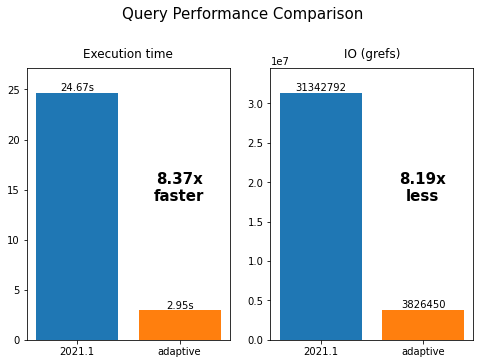

In [3]:
query("SELECT AVG(total_amount) AS \"Average Fare\" FROM NYTaxi.RowRides WHERE passenger_count > 2 AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-06-30'", compare="adaptive")
plot_compare(False)

### And with columnar storage

This time, we'll run the same query against a columnar-organized version of the exact same table.

```sql
SELECT AVG(total_amount) AS "Average Fare" 
  FROM NYTaxi.Rides 
WHERE passenger_count > 2
      AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-06-30'
```


Execution time: 0.152s
Global references: 1,774
Bytes read: 493,200 kB (0 kB physical)


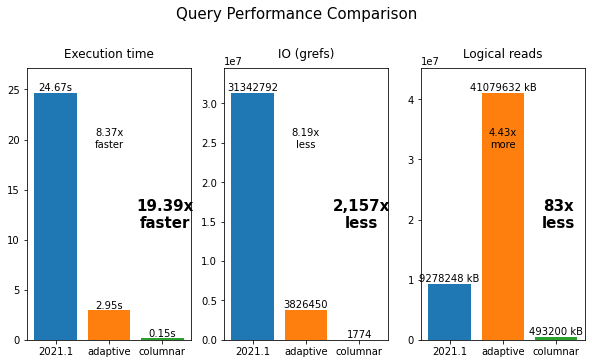

In [4]:
query("SELECT AVG(total_amount) AS \"Average Fare\" FROM NYTaxi.Rides WHERE passenger_count > 2 AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-06-30'", compare="columnar")
plot_compare()

## How does such a query plan look?

This script tracks prior query plans, so let's take a closer look at how these work for columnar tables. You'll see how it uses vectorized processing, handling the data chunk by chunk and applying vector operations to such chunks of column data as a whole, rather than loop through per-row values. This vectorized execution provides the great performance columnar storage brings to IRIS SQL.

In [5]:
print(plans[-1])

<plans>
 <plan>
 <sql>
  SELECT AVG(total_amount) AS "Average Fare" FROM NYTaxi.Rides WHERE passenger_count > 2 AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-06-30' /*#OPTIONS {"xDBCIsoLevel":"0"} */
 </sql>
 <cost value=""/>
 Call module C.
 From each parallel process:
     Accumulate the count([value]).
     Accumulate the sum([value]).
 <module name="C" top="1">
 Partition extent bitmap NYTaxi.Rides.%%DDLBEIndex, and in parallel, for each partition, looping on bitmap chunks.
 For each bitmap chunk:
     Read columnar index NYTaxi.Rides._CDM_tpeppickupdatetime, using the given chunk number.
     Apply vector and bitmap operations <=, >=, and & to produce a filter.
     Read columnar index NYTaxi.Rides._CDM_passengercount, using the given chunk number.
     Apply vector and bitmap operations >, &, defined, and & to produce a filter.
     Read columnar index NYTaxi.Rides._CDM_totalamount, using the given chunk number.
     Apply vector operations sum and count.
     Accumulat

## A more complex query

Now let's consider a more complex query, using GROUP BY, ORDER BY and an OUTER JOIN between our columnar and a row-organized table (which many other vendors simply don't allow). 

Even though the current 2022.2 developer preview (at the time of writing) is not yet using the kernel-level vectorized joiner module, we're already using nice vectorized processing for everything up to that point, and get really neat performance when running this against the columnar table.

```sql
SELECT Zone, Borough, Tip 
  FROM (
        SELECT TOP 10 PULocationID, AVG(tip_amount / fare_amount) AS Tip
          FROM NYTaxi.RowRides
         WHERE fare_amount > 0
      GROUP BY PULocationID
      ORDER BY 2 DESC
        ) r 
        LEFT OUTER JOIN NYTaxi.Zones z ON r.PULocationID = z.LocationID
```


Execution time: 16.919s
Global references: 39,649,225
Bytes read: 5,975,848 kB (0 kB physical)


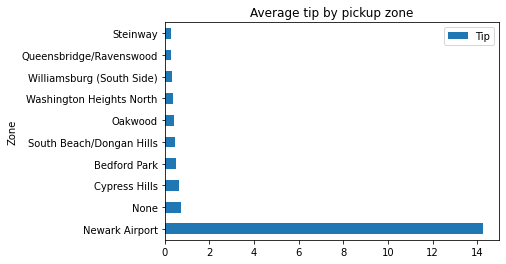

In [6]:
reset_compare()
r = query("SELECT Zone, Borough, Tip FROM (SELECT TOP 10 PULocationID, AVG(tip_amount / fare_amount) AS Tip FROM NYTaxi.RowRides WHERE fare_amount > 0 GROUP BY PULocationID ORDER BY 2 DESC) r LEFT JOIN NYTaxi.Zones z ON r.PULocationID = z.LocationID",  dtypes = { "Tip": np.double }, compare="row")
r.plot.barh(x="Zone", y="Tip", title="Average tip by pickup zone");


Execution time: 2.069s
Global references: 2,506
Bytes read: 750,032 kB (0 kB physical)


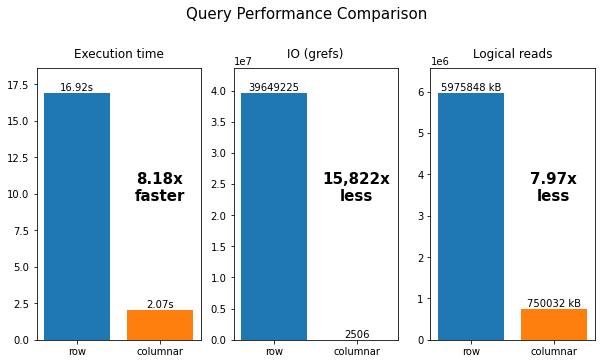

In [7]:
r = query("SELECT Zone, Borough, Tip FROM (SELECT TOP 10 PULocationID, AVG(tip_amount / fare_amount) AS Tip FROM %PARALLEL NYTaxi.Rides WHERE fare_amount > 0 GROUP BY PULocationID ORDER BY 2 DESC) r LEFT JOIN NYTaxi.Zones z ON r.PULocationID = z.LocationID",  dtypes = { "Tip": np.double }, compare="columnar")
plot_compare()

In [8]:
print(plans[-1])

<plans>
 <plan>
 <sql>
  SELECT Zone, Borough, Tip FROM (SELECT TOP 10 PULocationID, AVG(tip_amount / fare_amount) AS Tip FROM %PARALLEL NYTaxi.Rides WHERE fare_amount > 0 GROUP BY PULocationID ORDER BY 2 DESC) r LEFT JOIN NYTaxi.Zones z ON r.PULocationID = z.LocationID /*#OPTIONS {"xDBCIsoLevel":"0"} */
 </sql>
 <cost value="55562"/>
 Call module O, which populates temp-file A.
 Call module S, which populates temp-file B.
 Read temp-file B, looping on AVG and a counter.
 For each row:
     Read index map NYTaxi.Zones.LocationID, using the given LocationID, and getting ID.
     Read master map NYTaxi.Zones.IDKEY, using the given idkey value.
     Generate a row padded with NULL for table NYTaxi.Zones if no row qualified.
     Output the row.
 <module name="O" top="1">
 Read temp-file C, looping on a counter.
 For each row:
     Check distinct values for PULocationID using temp-file A,
         subscripted by PULocationID.
     For each distinct row:
         Add a row to temp-file A, s

## Quality Time

In classic row storage, it's often useful (or at least tempting) to add index structures in support of important queries. However, there are limits to what is reasonable, as storage consumption adds up and each index implies a little bit of extra work upon ingestion and updates. 

The following query is kind of a data quality check, looking for records where the pickup time is after the dropoff time. There is no sensible DBA who'd create an index to support this query, so the row-based table will require a full table scan, whereas the columnar one can use its regular vectorized processing. Note also how this benefits both the number of IOs and the total number of blocks / Kbs read.

```sql
 SELECT COUNT(*) AS TimeTravel 
   FROM NYTaxi.RowRides
  WHERE tpep_pickup_datetime > tpep_dropoff_datetime
```

In [9]:
reset_compare()
query("SELECT COUNT(*) AS TimeTravel FROM NYTaxi.RowRides WHERE tpep_pickup_datetime > tpep_dropoff_datetime", compare="row")


Execution time: 10.333s
Global references: 39,649,206
Bytes read: 5,972,424 kB (0 kB physical)


,TimeTravel
0,48290



Execution time: 1.839s
Global references: 1,867
Bytes read: 661,000 kB (0 kB physical)


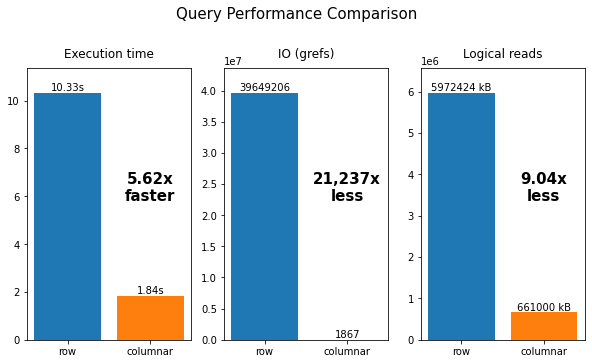

In [10]:
query("SELECT COUNT(*) AS TimeTravel FROM NYTaxi.Rides WHERE tpep_pickup_datetime > tpep_dropoff_datetime", compare="columnar")
plot_compare()

## Bread & Butter

And finally, let's try a few queries that are right in the wheelhouse of columnar storage & vectorized query processing.

```sql
SELECT AVG(fare_amount) AS Fare, AVG(tip_amount) AS Tip
  FROM NYTaxi.RowRides
 WHERE payment_type = 1
```


Execution time: 13.089s
Global references: 39,649,206
Bytes read: 5,972,856 kB (8 kB physical)


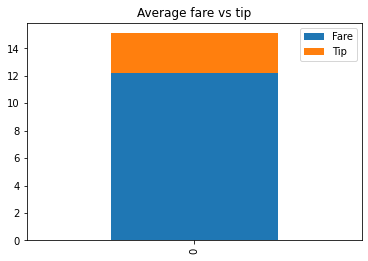

In [11]:
reset_compare()
r = query("SELECT AVG(fare_amount) AS Fare, AVG(tip_amount) AS Tip FROM NYTaxi.RowRides WHERE payment_type = 1", compare="row")
r.plot.bar(stacked=True, title="Average fare vs tip");


Execution time: 0.194s
Global references: 2,469
Bytes read: 698,704 kB (0 kB physical)


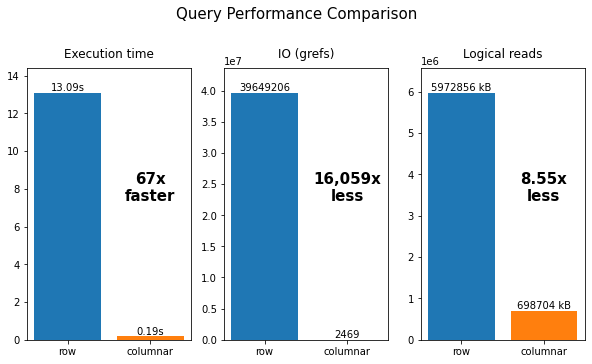

In [12]:
r = query("SELECT AVG(fare_amount) AS Fare, AVG(tip_amount) AS Tip FROM NYTaxi.Rides WHERE payment_type = 1", compare="columnar")
plot_compare()

## And a really simple aggregate just for fun

One more..

```sql
SELECT SUM(passenger_count) FROM NYTaxi.RowRides
```

In [13]:
reset_compare()
query("SELECT SUM(passenger_count) FROM NYTaxi.RowRides",compare="row")


Execution time: 0.089s
Global references: 4,543
Bytes read: 28,048 kB (0 kB physical)


,Aggregate_1
0,55188091



Execution time: 0.025s
Global references: 1,247
Bytes read: 54,784 kB (0 kB physical)


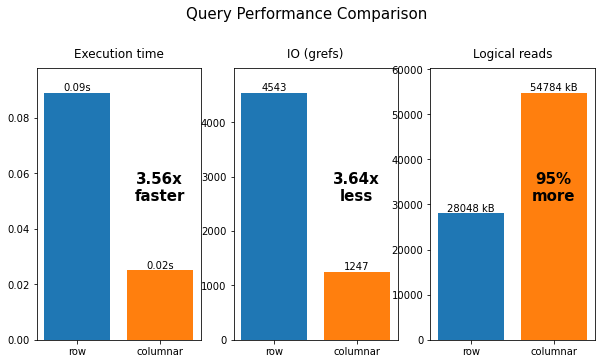

In [14]:
query("SELECT SUM(passenger_count) FROM NYTaxi.Rides",compare="columnar")
plot_compare()

## What happened!?

Now that was somewhat surprising. This last query was hardly faster or even _slower_ on the columnar table vs the row-organized table. How did that happen? Let's look at the query plan for the query on the row-organized table.

In [15]:
print(plans[-2])

<plans>
 <plan>
 <sql>
  SELECT SUM(passenger_count) FROM NYTaxi.RowRides /*#OPTIONS {"xDBCIsoLevel":"0"} */
 </sql>
 <cost value=""/>
 Call module C.
 Output the row.
 <module name="C" top="1">
 Read bitmap index NYTaxi.RowRides.passenger_count, looping on passenger_count.
 For each row:
     Call module D.
     Accumulate the sum(passenger_count).
 </module>
 <module name="D" top="1">
 Read bitmap index NYTaxi.RowRides.passenger_count, using the given passenger_count, and looping on bitmap chunks.
 For each bitmap chunk:
     Accumulate the count(bits).
 </module>
 </plan>
</plans>


### That was SIMD vs SIMD!

The row-organized table has a bitmap index on the passenger_count field, which has everything the optimizer needs to calculate the result of the query using fast $bitcount() operations. These are also highly optimized kernel-level functions operating on entire chunks of 64k rows at a time, so we saw SIMD-optimized functions (on an array of booleans) compete against SIMD-optimized functions (on an array of integers). That was a pretty close call after all.

Let's turn to an example where it's unlikely there'd be a bitmap that'd allow this exceptional fast lane for row storage, and we'll quickly see the reassuring >10x performance boost offered by Columnar Storage.

In [16]:
reset_compare()
query("SELECT AVG(fare_amount) FROM NYTaxi.RowRides",compare="row")


Execution time: 10.934s
Global references: 39,649,206
Bytes read: 5,972,416 kB (0 kB physical)


,Aggregate_1
0,12.752789



Execution time: 0.079s
Global references: 1,247
Bytes read: 333,632 kB (0 kB physical)


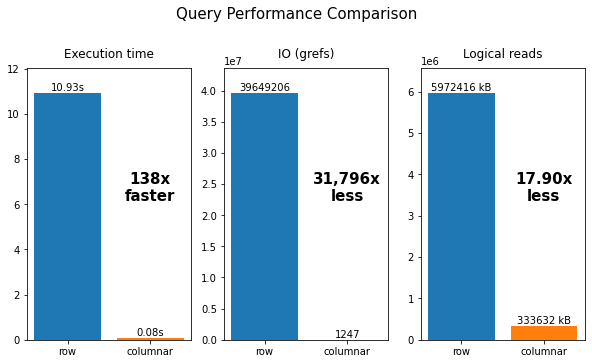

In [17]:
query("SELECT AVG(fare_amount) FROM NYTaxi.Rides",compare="columnar")
plot_compare()